In [ ]:
!wget https://github.com/stefyste/RIAWELC/blob/main/Dataset_partitioned/RIAWELC_dataset.part01.rar

--2023-07-04 20:30:17--  https://github.com/stefyste/RIAWELC/blob/main/Dataset_partitioned/RIAWELC_dataset.part01.rar
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘RIAWELC_dataset.part01.rar’

RIAWELC_dataset.par     [ <=>                ] 139.14K  --.-KB/s    in 0.009s  

2023-07-04 20:30:17 (14.6 MB/s) - ‘RIAWELC_dataset.part01.rar’ saved [142484]



In [ ]:
! git clone https://github.com/stefyste/RIAWELC.git

Cloning into 'RIAWELC'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 528 (delta 4), reused 103 (delta 0), pack-reused 382
Receiving objects: 100% (528/528), 471.32 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (20/20), done.


In [ ]:
%cd RIAWELC

In [ ]:
%cd Dataset_partitioned

/content/RIAWELC/Dataset_partitioned


In [ ]:
!pip install pyunpack
!pip install patool

In [ ]:
import os
from pyunpack import Archive

rar_file = '/content/RIAWELC/Dataset_partitioned/RIAWELC_dataset.part01.rar'
output_dir = '/content/extracted_data'
os.mkdir(output_dir)
Archive(rar_file).extractall(output_dir)

In [ ]:
train_dir = '/content/extracted_data/DB - Copy/training'
validation_dir = '/content/extracted_data/DB - Copy/validation'
test_dir = '/content/extracted_data/DB - Copy/testing'

**Preprocessing**



In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

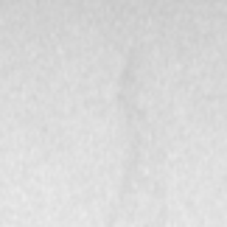

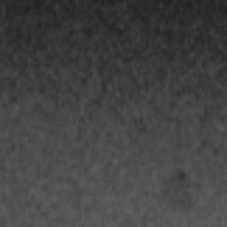

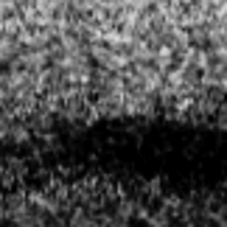

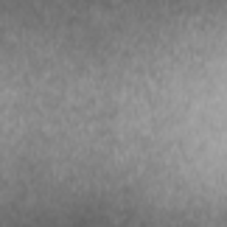

In [ ]:
img_path1 = '/content/extracted_data/DB - Copy/training/Difetto1/RRT-101R_Img1_A80_S1_[12][8].png'
img_path2 = '/content/extracted_data/DB - Copy/training/Difetto2/RRT-102R_Img1_A80_S1_[2][32].png'
img_path3 = '/content/extracted_data/DB - Copy/training/Difetto4/RRT-107R_Img2_A80_S5_[6][108].png'
img_path4 = '/content/extracted_data/DB - Copy/training/NoDifetto/RRT-09R_Img1_A80_S9_[2][20].png'

image_paths = [img_path1 , img_path2 , img_path3 ,img_path4]

images=[]
for image_path in image_paths:

    img= cv.imread(image_path)
    images.append(img)
    cv2_imshow(img)
    cv.waitKey(0)

cv.destroyAllWindows()


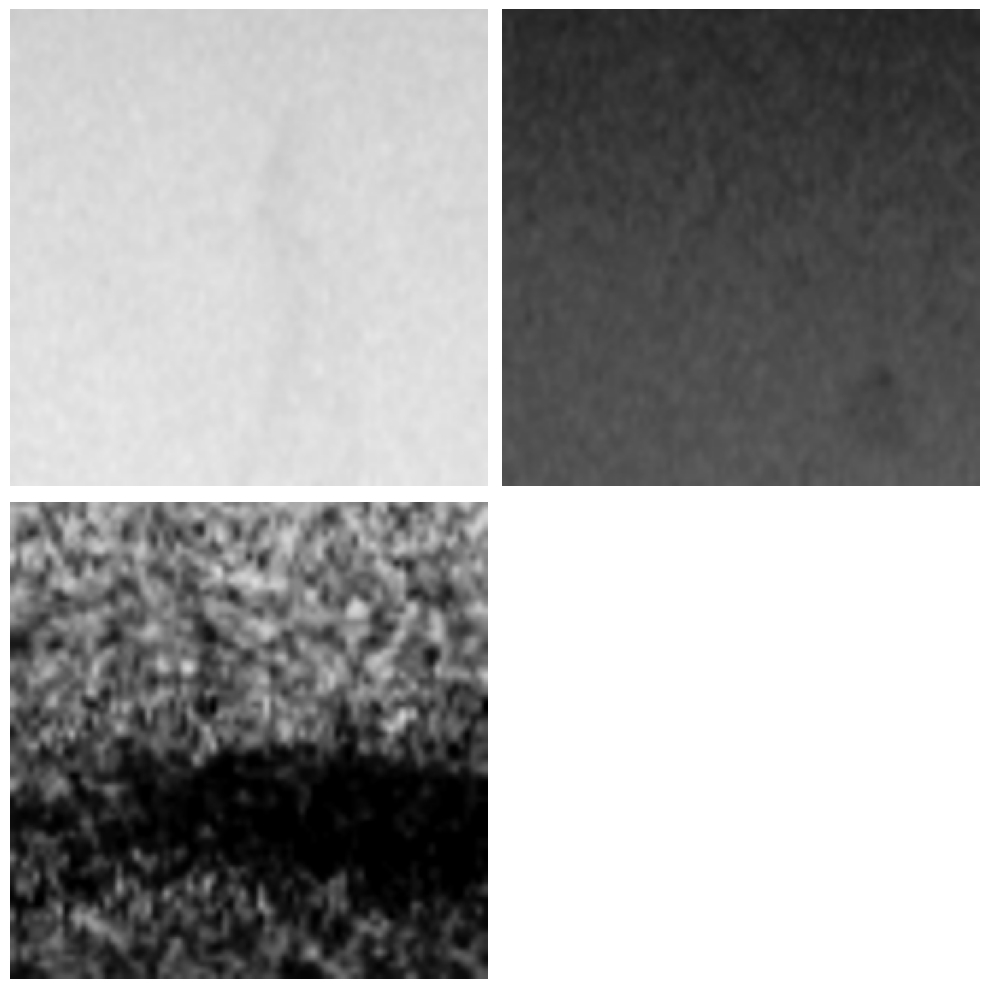

In [ ]:
fig = plt.figure(figsize=(10, 10))

axes=[]
images=[]

for i in range(3):
  ax = fig.add_subplot(2, 2, i+1)
  image = plt.imread(image_paths[i])
  image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
  images.append(image)
  ax.imshow(image)
  ax.axis('off')
  axes.append(ax)

fig.tight_layout()
plt.show()

1. Min-Max normalisation on the given image.

In [ ]:
def MinMaxNormalise(img):
    norm_img = (img - img.min()) / (img.max() - img.min())

    return norm_img

2. Histogram Equalization

3. Contrast-Limited Adaptive Histogram Equalisation (CLAHE)

In [ ]:
def clahe(img, clip=2.0, tile=(8, 8)):
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    '''

    # Convert to uint8.
    #img= (img * 255).astype(np.uint8)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # img = skimage.img_as_ubyte(img)
    img = cv.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv.NORM_MINMAX,
        dtype=cv.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img

Test CLAHE

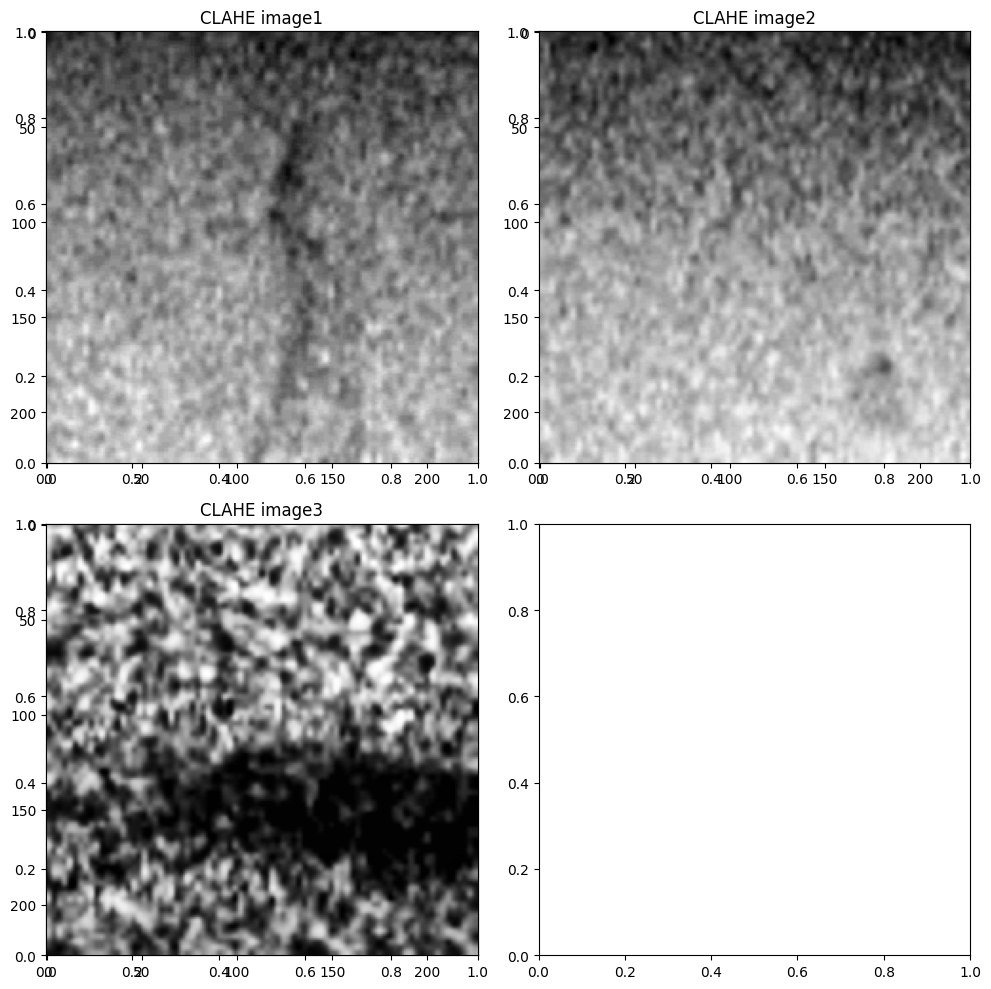

In [ ]:
clahe_img_list = []


arr_norm = [MinMaxNormalise(a) for a in images]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes=[]
for i in range(3):

    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(arr_norm[i], cmap="gray")
    clahe_img = clahe(img=arr_norm[i])
    clahe_img_list.append(clahe_img)

    ax.imshow(clahe_img_list[i], cmap="gray")
    ax.set_title(f"CLAHE image_{i+1}")
    axes.append(ax)

plt.tight_layout()
plt.show()

**SqueezNet**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Conv2D,
    Concatenate,
    Input,
    MaxPool2D,
    GlobalAvgPool2D,
    Activation
)

In [ ]:
def squeezenet(input_shape, n_classes):

  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output


  input = Input(input_shape)

  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)

  output = Activation('softmax')(x)

  model = Model(input, output)
  return model